# SNA

In [1]:
# automatically reload imports before executing any line in case you changed something
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import read_graph
import viz
import utils

## load data

In [3]:
df = pd.read_csv("../data/Following_Ignoring_Relationships.csv.sample", delimiter=";")
fol_df = df[df["ID_CommunityConnectionType"]==1]
fol_df = fol_df[fol_df["ID_CommunityIdentity"] != fol_df["ID_CommunityIdentityConnectedTo"]]
ign_df = df[df["ID_CommunityConnectionType"]==2]

In [4]:
fol_df[fol_df["ID_CommunityIdentity"] != fol_df["ID_CommunityIdentityConnectedTo"]]

,ID_CommunityIdentity,ID_CommunityIdentityConnectedTo,ID_CommunityConnectionType
0,1778,246490,1
2,9030,23875,1
3,9030,508504,1
5,10569,91850,1
6,10569,547472,1
...,...,...,...
958,27967,196753,1
959,27967,225324,1
960,27967,580733,1
962,29486,137950,1


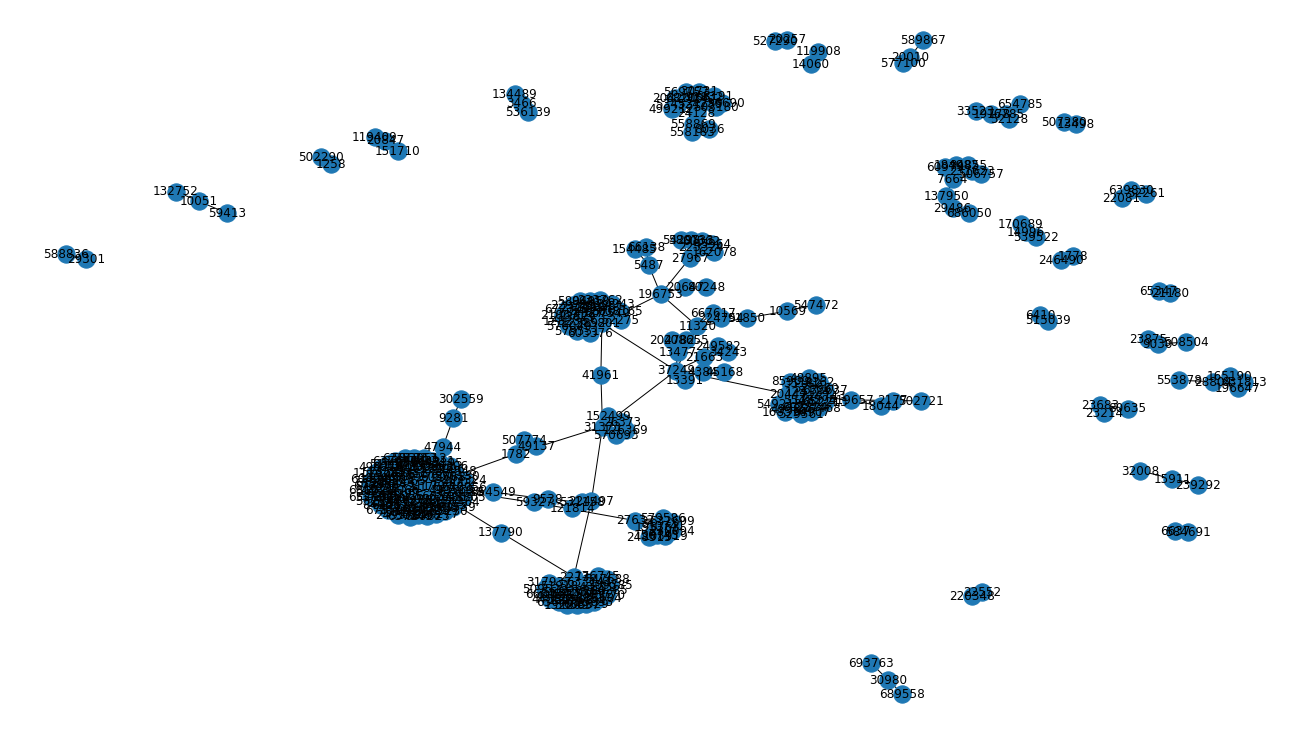

In [5]:
plt.figure(figsize=(18,10))

fol_G = nx.from_pandas_edgelist(fol_df[:1000], source="ID_CommunityIdentity", target="ID_CommunityIdentityConnectedTo")
nx.draw(fol_G, with_labels=True, arrows=True)
plt.show()

## Show shared users between articles

In [6]:
all_postings = utils.read_all_postings()
all_votes = utils.read_all_votes()

In [7]:
postings_1 = all_postings.query("PostingCreatedAt < '2019-05-02'")
votes_1 = all_votes.query("VoteCreatedAt < '2019-05-02'")
postings_1.shape, votes_1.shape

((10446, 14), (63909, 8))

In [8]:
G_art = read_graph.get_articles_shared_users(postings_1)
G_int = read_graph.get_all_users_interactions(postings_1, votes_1)
print("info", nx.info(G_art))
print("info", nx.info(G_int))

info Name: 
Type: Graph
Number of nodes: 95
Number of edges: 1283
Average degree:  27.0105
info Name: 
Type: DiGraph
Number of nodes: 12101
Number of edges: 59756
Average in degree:   4.9381
Average out degree:   4.9381


In [9]:
ccs = [c for c in (G_art.subgraph(c) for c in nx.connected_components(G_art))]
ccs.sort(key=lambda g: len(g.nodes), reverse=True)
len(ccs)

1

In [10]:
wccs = [c for c in (G_int.subgraph(c) for c in nx.weakly_connected_components(G_int))]
wccs.sort(key=lambda g: len(g.nodes), reverse=True)
sccs = [c for c in (G_int.subgraph(c) for c in nx.strongly_connected_components(G_int))]
sccs.sort(key=lambda g: len(g.nodes), reverse=True)
len(wccs), len(sccs)

(104, 9739)

In [11]:
print([len(c.nodes) for c in ccs[:10]])
print([len(c.nodes) for c in wccs[:10]])
print([len(c.nodes) for c in sccs[:10]])

[95]
[6054, 3752, 2072, 7, 5, 4, 4, 4, 3, 3]
[1586, 584, 182, 2, 2, 2, 2, 2, 2, 2]


In [12]:
nx.set_node_attributes(G_art, nx.clustering(G_art), "c_coef")
nx.set_node_attributes(G_art, dict(nx.degree(G_art)), "degree")

nx.set_node_attributes(G_int, nx.clustering(G_int), "c_coef")
nx.set_node_attributes(G_int, utils.get_in_degrees(G_int), "in_degree")

In [13]:
channels = list(postings_1["ArticleChannel"].unique())
nx.set_node_attributes(G_art, {n: channels.index(postings_1.query("ID_Article == '{}'".format(n))["ArticleChannel"].unique()[0]) for n in G_art.nodes()}, "ArticleChannel")

### Plot articles

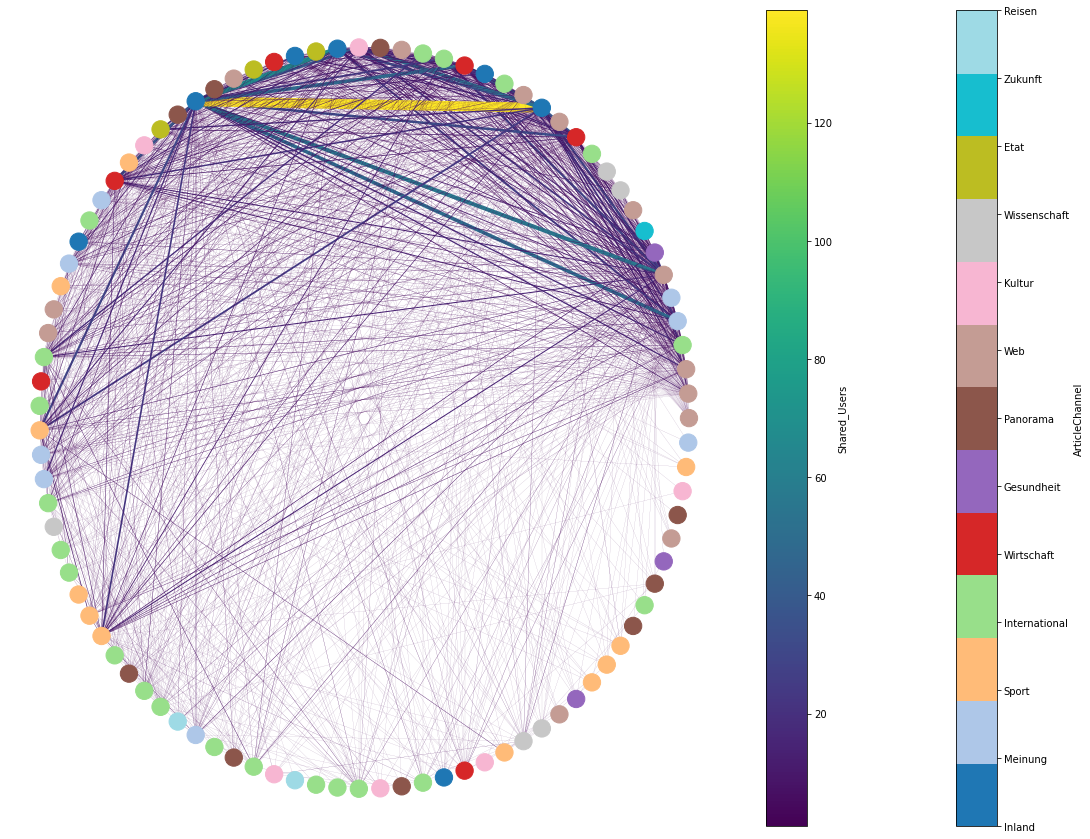

In [14]:
viz.plot_colored_graph(G_art, node_color_attr="ArticleChannel", edge_color_attr="Shared_Users", edge_width_factor=10, pos=nx.circular_layout(G_art), figsize=(20, 15), node_cmap=plt.cm.get_cmap('tab20', len(channels)), node_ticks=channels)

### Plot 3rd largest strongly connected component

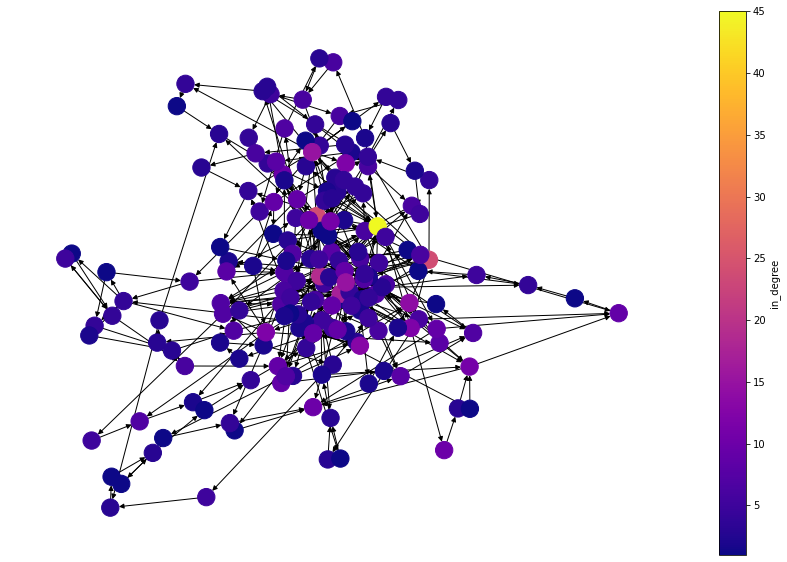

In [15]:
g_int = G_int.subgraph(sccs[2])
viz.plot_colored_graph(g_int, node_color_attr="in_degree", figsize=(15, 10))

### Plot 5 largest distinct cliques 

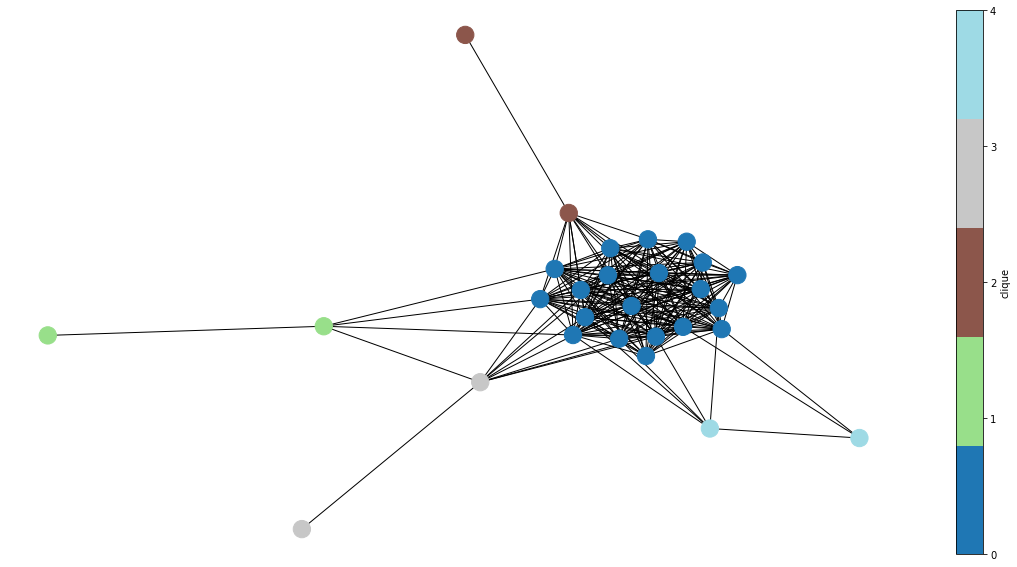

In [16]:
distinct_cliques = utils.get_distinct_cliques(G_art)
for i, c in enumerate(distinct_cliques):
    nx.set_node_attributes(G_art, {n: i for n in c}, "clique")
g_art = G_art.subgraph(sum(distinct_cliques, []))
viz.plot_colored_graph(g_art, "clique", figsize=(20, 10), node_cmap=plt.cm.get_cmap("tab20", len(distinct_cliques)), node_ticks=range(len(distinct_cliques)))

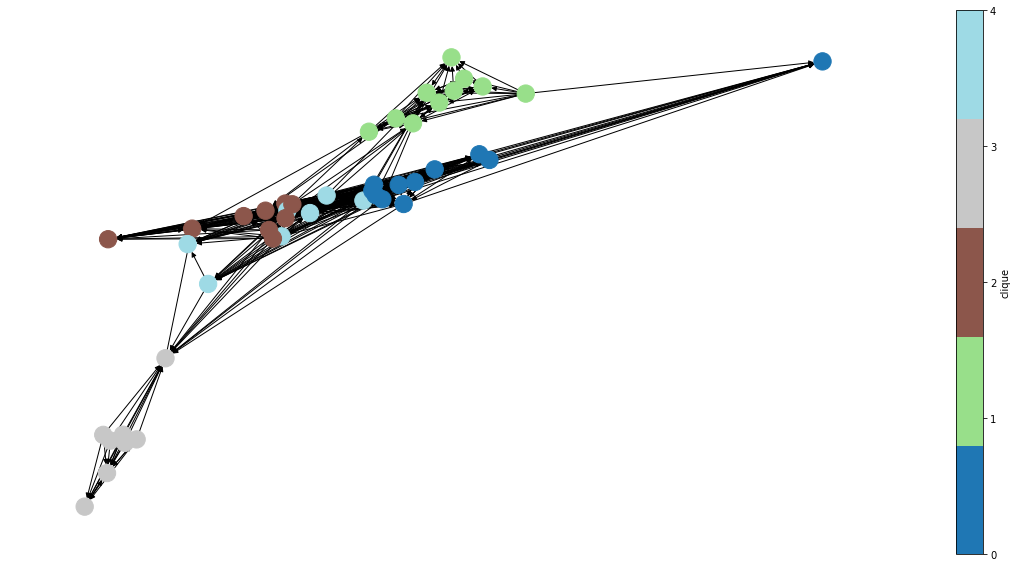

In [17]:
n_cliques = 5
distinct_cliques = utils.get_distinct_cliques(G_int, n=n_cliques)
for i, c in enumerate(distinct_cliques):
    nx.set_node_attributes(G_int, {n: i for n in c}, "clique")
g_int = G_int.subgraph(sum(distinct_cliques, []))
viz.plot_colored_graph(g_int, "clique", figsize=(20, 10), node_cmap=plt.cm.get_cmap("tab20", n_cliques), node_ticks=range(n_cliques))

## Show Inland comments network

Idea:
- 1: get community of people interested in Inland articles
  - Interest = any interaction on any Inland article ever 
  - maybe set some lower boundary (eg >= 10 interactions total)
- 2: for each day plot interactions between those users 
  - as graph with 1 node per user and an edge betwween users if there was at least 1 interaction on that day
  - Edge width = number of interactions between these users on that day
  - how to view so many plots in a sensible fashion?
- 3: calculate some metrics for each day and plot as line plot
  - total number of interactions
  - num interactions / interacting users to account for changing user numbers
  - others like connectedness / etc. ?

### show users with most interactions on day 1

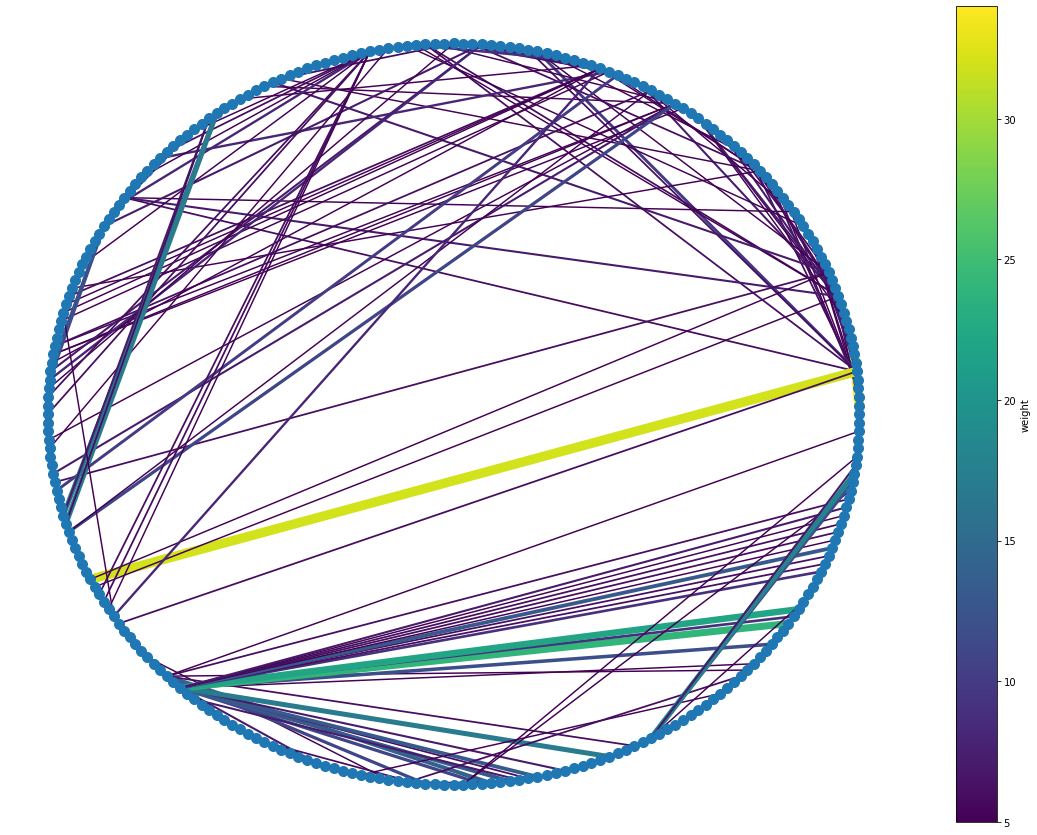

In [18]:
G_int_w = read_graph.get_weighted_interaction_graph(postings_1, votes_1, 5)
viz.plot_colored_graph(G_int_w, edge_color_attr="weight", edge_width_factor=10, figsize=(20, 15), node_size=100, pos=nx.circular_layout(G_int_w))

### show users with most interactions in Inland postings over the entire time frame

info: note the minimum threshold for displaying an edge (here 25) and the scale on the right for comparing between days

In [19]:
# Ibiza Artikel ist unter "Meinung", aber anderer Strache Artikel (Inland) am selben Tag hat eh ~5 mal mehr postings also bleib ich mal bei Inland
postings_inl = all_postings.query("ArticleChannel == 'Inland'")

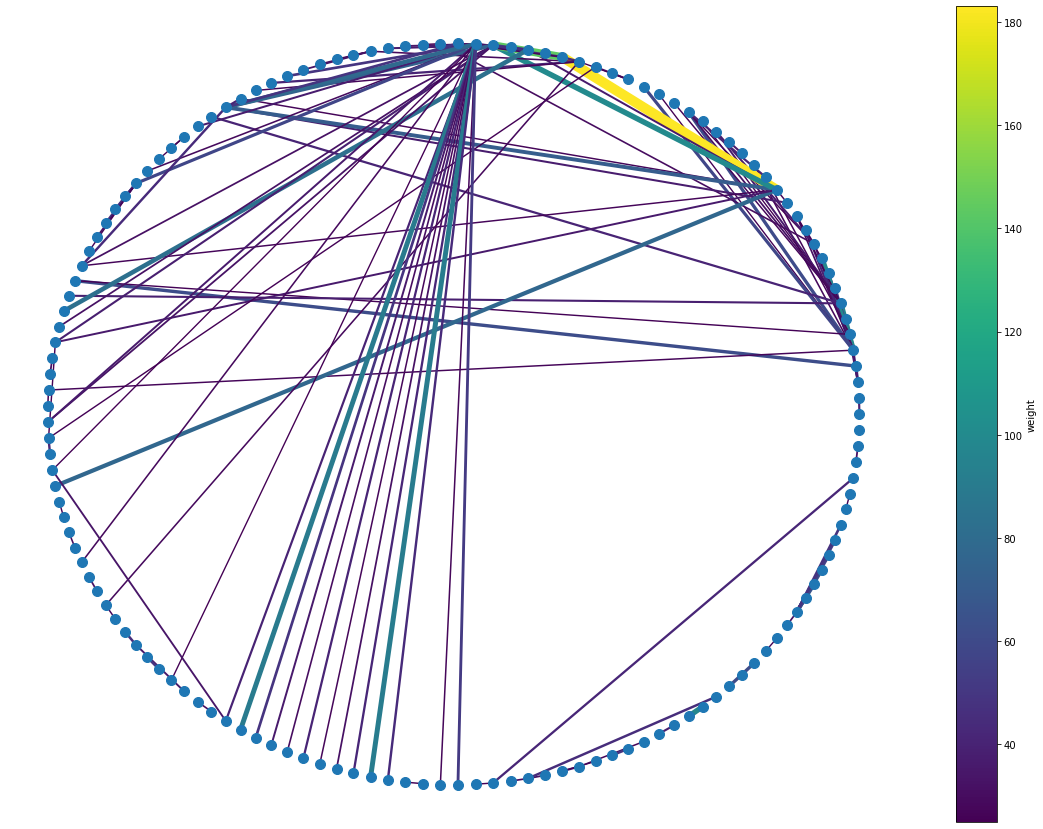

In [20]:
G_int_w = read_graph.get_weighted_interaction_graph(postings_inl, all_votes, 25)
viz.plot_colored_graph(G_int_w, edge_color_attr="weight", edge_width_factor=10, figsize=(20, 15), node_size=100, pos=nx.circular_layout(G_int_w))

### compare strache day with day before / after

In [21]:
postings_inl_0 = postings_inl.query("'2019-05-17' <= PostingCreatedAt & PostingCreatedAt < '2019-05-18'")
votes_0 = all_votes.query("'2019-05-17' <= VoteCreatedAt & VoteCreatedAt < '2019-05-18'")

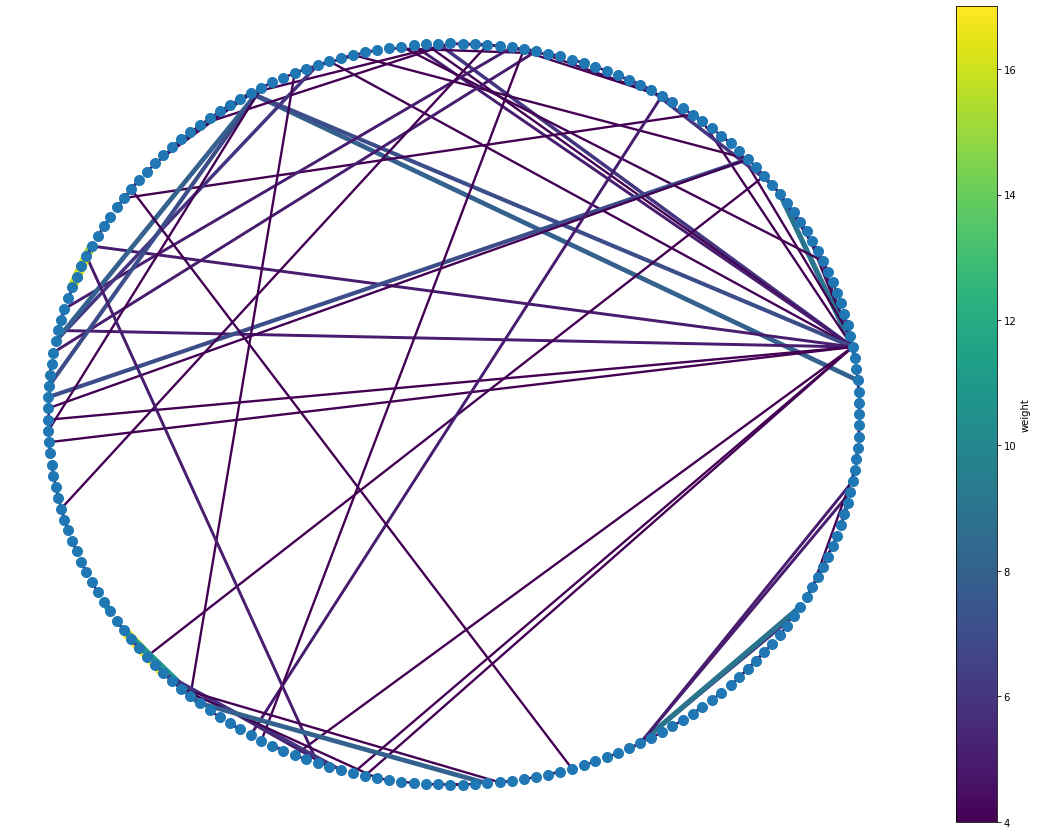

In [22]:
G_int_w = read_graph.get_weighted_interaction_graph(postings_inl_0, votes_0, 4)
viz.plot_colored_graph(G_int_w, edge_color_attr="weight", edge_width_factor=10, figsize=(20, 15), node_size=100, pos=nx.circular_layout(G_int_w))

#### day before

In [23]:
postings_inl_b = postings_inl.query("'2019-05-16' <= PostingCreatedAt & PostingCreatedAt < '2019-05-17'")
votes_b = all_votes.query("'2019-05-16' <= VoteCreatedAt & VoteCreatedAt < '2019-05-17'")

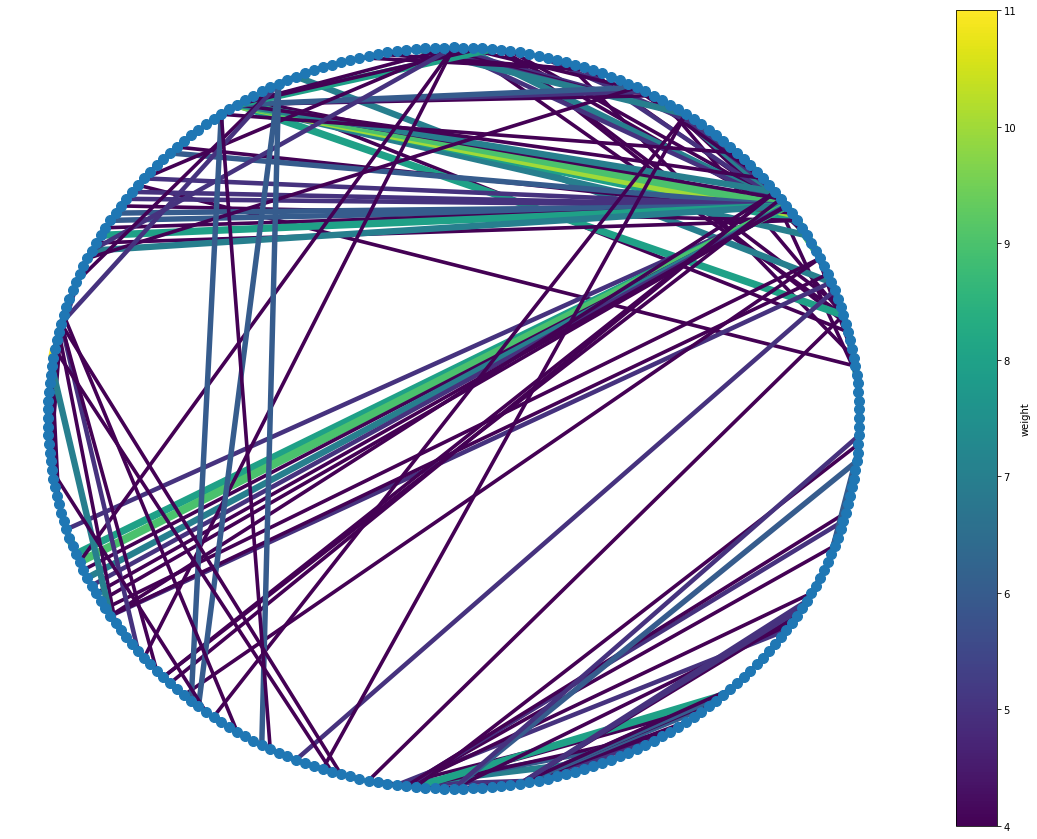

In [24]:
G_int_w = read_graph.get_weighted_interaction_graph(postings_inl_b, votes_b, 4)
viz.plot_colored_graph(G_int_w, edge_color_attr="weight", edge_width_factor=10, figsize=(20, 15), node_size=100, pos=nx.circular_layout(G_int_w))

a bit more than on strache day (scale only goes to 11 compared to 17 above)

#### day after

In [25]:
postings_inl_a = postings_inl.query("'2019-05-18' <= PostingCreatedAt & PostingCreatedAt < '2019-05-19'")
votes_a = all_votes.query("'2019-05-18' <= VoteCreatedAt & VoteCreatedAt < '2019-05-19'")

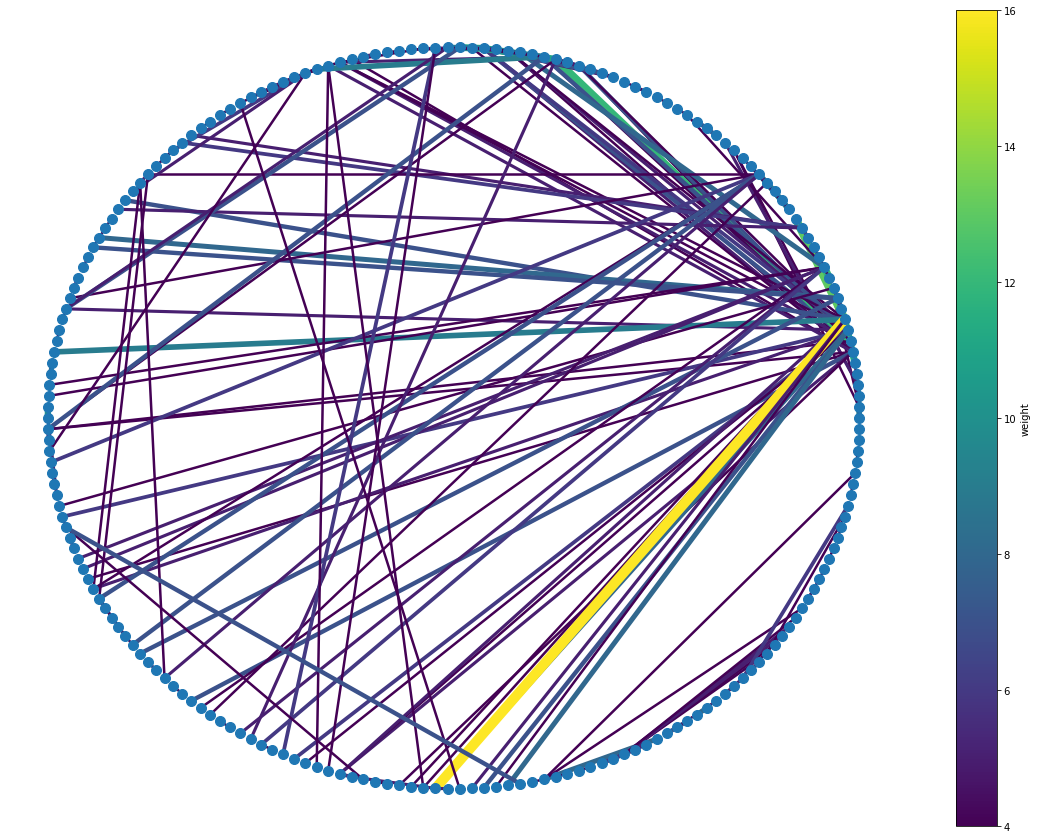

In [26]:
G_int_w = read_graph.get_weighted_interaction_graph(postings_inl_a, votes_a, 4)
viz.plot_colored_graph(G_int_w, edge_color_attr="weight", edge_width_factor=10, figsize=(20, 15), node_size=100, pos=nx.circular_layout(G_int_w))

a lot more than on strache day. Maybe most people read the post on the next day as it was posted in the afternoon?

#### 2 days after

In [27]:
postings_inl_a2 = postings_inl.query("'2019-05-19' <= PostingCreatedAt & PostingCreatedAt < '2019-05-20'")
votes_a2 = all_votes.query("'2019-05-19' <= VoteCreatedAt & VoteCreatedAt < '2019-05-20'")

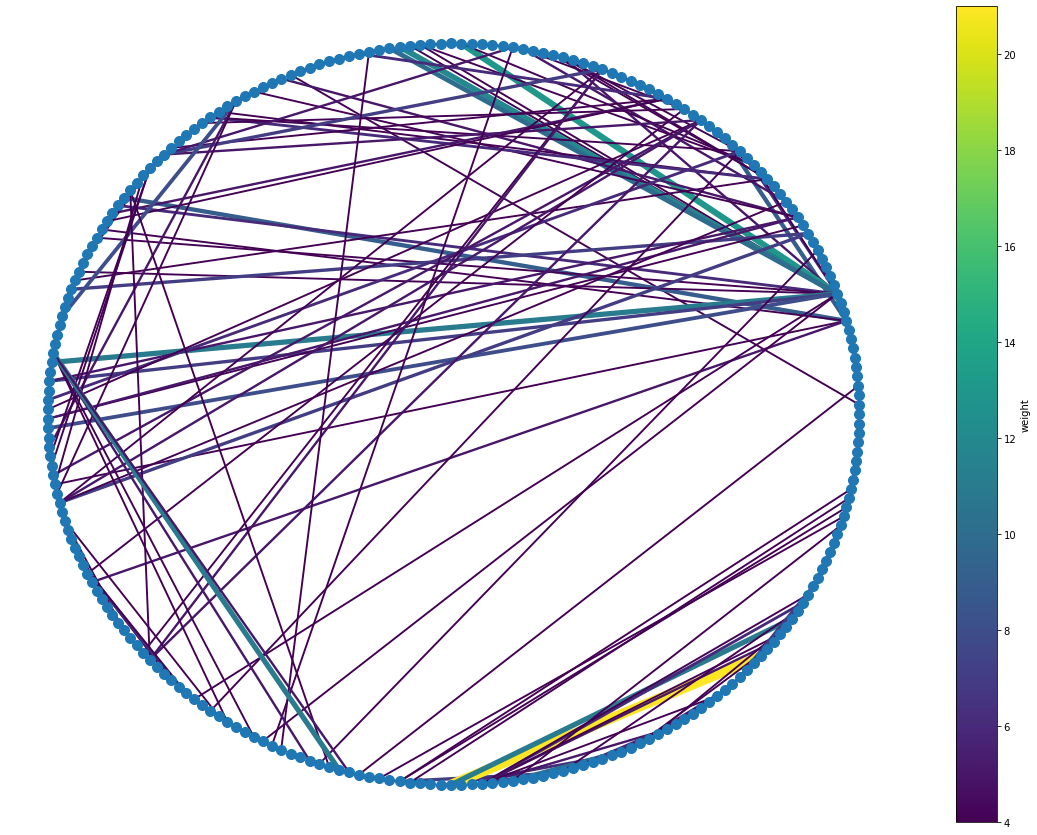

In [28]:
G_int_w = read_graph.get_weighted_interaction_graph(postings_inl_a2, votes_a2, 4)
viz.plot_colored_graph(G_int_w, edge_color_attr="weight", edge_width_factor=10, figsize=(20, 15), node_size=100, pos=nx.circular_layout(G_int_w))

still alot 2 days after (scale goes to 21 compared to 16)

## Compare number of interactions in Inland over time

In [29]:
connections = []
all_postings = []
# 01.05.2019 - 31.05.2019 Inland interactions (comment, like, dislike)
for i in range(0,31):
    startday = "2019-05-{}".format(str(1+i))
    endday = "2019-05-{}".format(str(1+i+1))
    postings = postings_inl.query("'{}' <= PostingCreatedAt & PostingCreatedAt < '{}'".format(startday,endday))
    votes = all_votes.query("'{}' <= VoteCreatedAt & VoteCreatedAt < '{}'".format(startday,endday))
    G = read_graph.get_all_users_interactions(postings, votes, multi_di_graph=True)
    connections.append(len(G.edges))
    all_postings.append(len(postings))

Text(0.5, 1.0, 'Interaction in Inland posts from 01.05.2019 until 31.05.2019')

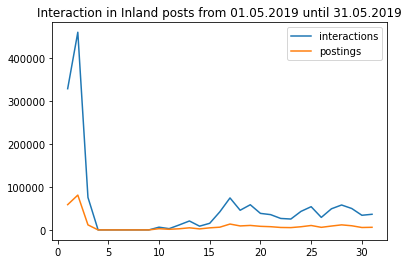

In [31]:
plt.plot(list(range(1,32)), connections)
plt.plot(list(range(1,32)), all_postings)
plt.legend(["interactions","postings"])
plt.title("Interaction in Inland posts from 01.05.2019 until 31.05.2019")